In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
sys.path.append('../visualization')
# import modules
import visualize
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
datasize = 'full'
location = 'tromso'
data_date = '202204'
eval_date = '202205'

# load network from pickle
model = data_date+'_waypoints_DP10_HDBSCAN12_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 12,
 'clustering_min_cluster_size': 12,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-02, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 1.e-02, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e-04]]),
 'graph_generation_max_distance': 10,
 'graph_generation_max_angle': 45}

In [4]:
# load evaluation data
eval_file = eval_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + eval_file + '.parquet'
test_gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
test_gdf.to_crs(crs, inplace=True)  # Transformation
all_test_trajectories = mpd.TrajectoryCollection(test_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 0
selection_end = len(all_test_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = test_gdf.mmsi.unique()[selection]
test_trajectories = all_test_trajectories.filter('mmsi', mmsis.tolist())

In [5]:
# merge stop points
network.merge_stop_points(max_speed=2)
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 565 (1 isolated)
Number of edges: 2181
------------------------


Evaluating graph on 1734 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done! Time elapsed for evaluation: 61.82 minutes
Success rates:
                   mmsi      SSPD  distances  fraction_covered
message                                                       
attempt        0.026528  0.026528   0.026528          0.026528
no_intersects  0.150519  0.000000   0.000000          0.150519
no_path        0.000577  0.000000   0.000000          0.000577
success        0.822376  0.822376   0.822376          0.822376

 --------------------------- 

Fraction of NaN results: 0.151

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.890 

Mean distance      = 156.45 m
Median distance    = 78.90 m
Standard deviation = 344.31 m 



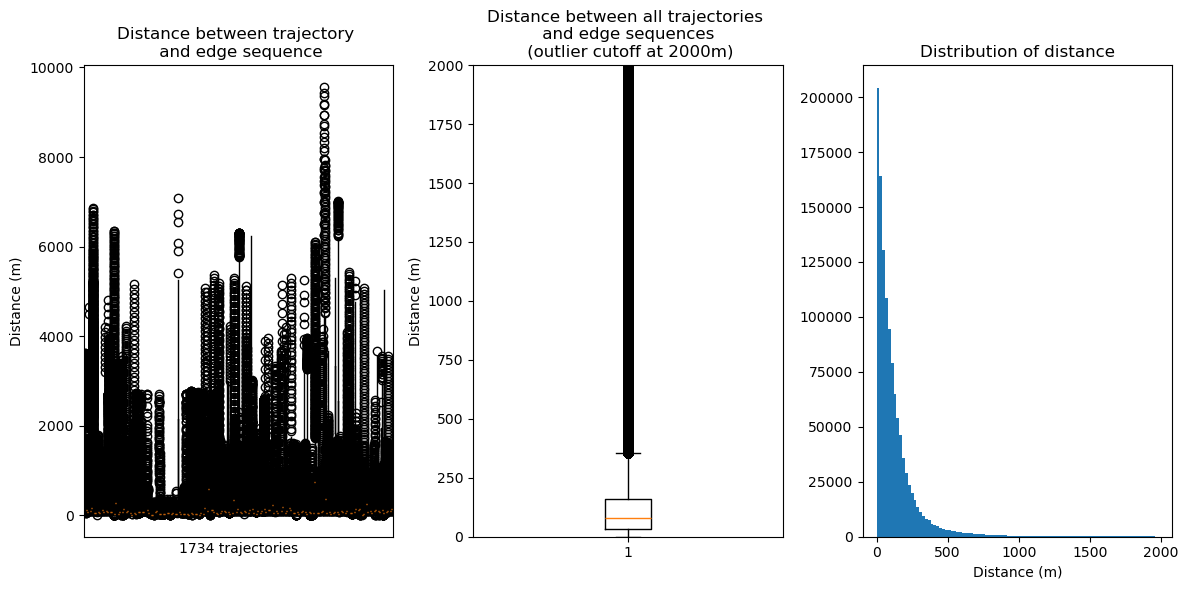

In [6]:
# evaluate all trajectories on the current network to create a training dataset for this specific network
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(test_trajectories)

In [14]:
grouped = all_paths.groupby('mmsi')

In [16]:
all_paths

,mmsi,orig,dest,geometry,message
0,205203000_0_2022-05-06 04:25:01,207,202,"LINESTRING (842910.968 7748203.739, 843805.491...",success
0,205203000_0_2022-05-06 04:25:01,202,200,"LINESTRING (843805.491 7747000.487, 845051.446...",success
0,205203000_0_2022-05-06 04:25:01,200,235,"LINESTRING (845051.446 7745785.600, 848044.144...",success
0,205203000_0_2022-05-06 04:25:01,235,256,"LINESTRING (848044.144 7742201.703, 851752.966...",success
0,205203000_0_2022-05-06 04:25:01,256,336,"LINESTRING (851752.966 7739649.741, 857697.368...",success
...,...,...,...,...,...
0,578000700_2_2022-05-26 22:09:22,364,363,"LINESTRING (890408.618 7772798.149, 890771.998...",success
0,578000700_2_2022-05-26 22:09:22,363,360,"LINESTRING (890771.998 7773009.481, 891458.077...",success
0,578000700_2_2022-05-26 22:09:22,360,392,"LINESTRING (891458.077 7773568.639, 893435.303...",success
0,578000700_2_2022-05-26 22:09:22,392,391,"LINESTRING (893435.303 7774756.482, 894240.294...",success


In [20]:
from shapely import LineSTring
grouped = all_paths.groupby('mmsi')['geometry'].apply(lambda x: LineString(x.tolist())).reset_index()

# Create a GeoDataFrame from the result
concatenated_gdf = gpd.GeoDataFrame(grouped, geometry='geometry', crs=df.crs)

NameError: name 'LineString' is not defined